<img align="center" style="max-width: 900px; height: auto" src="../assets/banner.png">

###  Coding Challenge Template - EuroSAT Classification

<img align="right" style="max-width: 200px; height: auto" src="../assets/hsg_logo.png">
<img align="center" style="max-width: 300px; height: auto" src="./sentinel2.jpg">

7,854,1.00 MCS Machine Learning, University of St.Gallen (HSG)

**Task**: Create a model to predict the most likely EuroSAT class for each image of the testset.

**Approach**: Build a complete machine learning pipeline including data loading, preprocessing, model architecture, training, and evaluation.

### Objectives:
- Create a dataset class and data-loader for training
- Design and implement a suitable model architecture
- Address the potential domain shift between train and test data
- Train and evaluate the model performance
- Generate predictions for the test set

---

## 🔥 OVERFITTING FIX - Key Improvements

**Problem**: 94% training accuracy but only 19% test accuracy (severe overfitting)

**Solutions Implemented**:

1. **Model Architecture**
   - Simplified network: Reduced from 512 to 256 channels in final conv layers
   - Removed one layer from classifier head
   - Maintained dropout for regularization (0.2-0.5)

2. **Regularization Techniques**
   - **Label Smoothing** (0.1): Prevents overconfident predictions
   - **Weight Decay** (1e-4): L2 regularization on all parameters
   - **Gradient Clipping**: Prevents exploding gradients
   - **Mixup Augmentation**: Interpolates between samples during training

3. **Enhanced Data Augmentation**
   - Rotation (±45°), flips (horizontal/vertical)
   - Translation (±10%), scaling (90-110%)
   - Random erasing (20% probability)
   - Noise injection, brightness, and contrast adjustments

4. **Training Improvements**
   - Lower learning rate: 1e-4 (was 1e-3)
   - Better scheduler: CosineAnnealingWarmRestarts
   - Increased epochs: 50 (with early stopping)
   - Test-Time Augmentation (TTA): 8 augmentations for robust predictions

5. **Prediction Strategy**
   - Test-Time Augmentation averages predictions across 8 augmented versions
   - More robust to variations in test data

---

## 1. Import Libraries and Setup

In [1]:
# Basic libraries
import os
import glob
import numpy as np
import pandas as pd
from pathlib import Path

# Raster data handling
import rasterio as rio
from rasterio.plot import reshape_as_image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Utilities
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Metal/GPU setup
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)

## 2. Configuration and Constants

In [ ]:
# Configuration
def get_device():
    """
    Select the best available device for training.
    Priority: Metal (MPS) > CUDA > CPU
    Metal Performance Shaders (MPS) is ideal for Mac with Apple Silicon
    """
    if torch.backends.mps.is_available():
        try:
            # Test if MPS actually works
            test_tensor = torch.zeros(1).to('mps')
            device = torch.device('mps')
            print("✓ Metal Performance Shaders (MPS) available and working")
            return device
        except Exception as e:
            print(f"⚠ MPS available but encountered issue: {e}")
            print("  Falling back to CPU")
    
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("✓ CUDA GPU available")
        return device
    
    device = torch.device('cpu')
    print("ℹ Using CPU for training")
    return device

CONFIG = {
    'eurosat_dir': '/Users/gian1/CODE/HSG/HS25/ML/ML2025-Lab/EuroSAT_MS',  # Correct absolute path
    'batch_size': 32,
    'num_epochs': 50,  # Increased epochs with early stopping
    'learning_rate': 0.0001,  # Reduced learning rate for better generalization
    'weight_decay': 1e-4,  # Added weight decay for L2 regularization
    'validation_split': 0.2,
    'num_workers': 0,  # Set to 0 for notebook compatibility
    'device': get_device()
}

# EuroSAT classes
CLASSES = [
    "AnnualCrop",
    "Forest", 
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake",
]

NUM_CLASSES = len(CLASSES)
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASSES)}
IDX_TO_CLASS = {idx: cls for idx, cls in enumerate(CLASSES)}

print(f"Number of classes: {NUM_CLASSES}")
print(f"Using device: {CONFIG['device']}")
print(f"Device type: {CONFIG['device'].type}")
if CONFIG['device'].type == 'mps':
    print(f"Metal GPU: {torch.mps.current_allocated_memory() / 1024**2:.1f} MB allocated")
elif CONFIG['device'].type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

✓ Metal Performance Shaders (MPS) available and working
Number of classes: 10
Using device: mps
Device type: mps
Metal GPU: 0.0 MB allocated


In [3]:
# Metal Performance Optimization Tips
def print_metal_optimization_info():
    """Print optimization information for Metal training on Mac."""
    if CONFIG['device'].type == 'mps':
        print("\n" + "="*60)
        print("Metal Performance Shaders (MPS) Optimization Tips")
        print("="*60)
        print("✓ Metal GPU training is enabled for faster performance")
        print("\nOptimization recommendations:")
        print("1. Use torch.mps.synchronize() for accuracy in timing measurements")
        print("2. For non-deterministic reproducibility issues, try:")
        print("   - torch.set_deterministic(True)")
        print("   - Disable certain ops if needed with env vars")
        print("3. Monitor performance: Peak memory usage is shown at start/end")
        print("4. Fallback to CPU if you encounter ops not yet supported by MPS")
        print("\nCurrently supported MPS features:")
        print("- Convolutions, pooling, normalization layers")
        print("- RNN layers (LSTM, GRU)")
        print("- Linear layers and most tensor operations")
        print("="*60 + "\n")

print_metal_optimization_info()


Metal Performance Shaders (MPS) Optimization Tips
✓ Metal GPU training is enabled for faster performance

Optimization recommendations:
1. Use torch.mps.synchronize() for accuracy in timing measurements
2. For non-deterministic reproducibility issues, try:
   - torch.set_deterministic(True)
   - Disable certain ops if needed with env vars
3. Monitor performance: Peak memory usage is shown at start/end
4. Fallback to CPU if you encounter ops not yet supported by MPS

Currently supported MPS features:
- Convolutions, pooling, normalization layers
- RNN layers (LSTM, GRU)
- Linear layers and most tensor operations



## 3. Data Utilities

In [4]:
def normalize_for_display(band_data):
    """Normalize multi-spectral imagery across bands for visualization."""
    band_data = np.array(band_data)
    lower_perc = np.percentile(band_data, 2, axis=(0,1))
    upper_perc = np.percentile(band_data, 98, axis=(0,1))
    
    return (band_data - lower_perc) / (upper_perc - lower_perc)

def normalize_for_model(band_data):
    """Normalize multi-spectral imagery for model training.
    
    Uses per-band standardization (z-score normalization) to handle
    the different value ranges across spectral bands.
    """
    band_data = band_data.astype(np.float32)
    
    # Per-band standardization
    # Calculate mean and std for each band
    band_means = np.mean(band_data, axis=(0, 1), keepdims=True)
    band_stds = np.std(band_data, axis=(0, 1), keepdims=True)
    
    # Avoid division by zero
    band_stds = np.where(band_stds == 0, 1.0, band_stds)
    
    # Normalize
    normalized = (band_data - band_means) / band_stds
    
    return normalized

def visualize_sample(img_data, title="Sample", figsize=(10, 5)):
    """Visualize a multi-spectral sample."""
    normalized_img = normalize_for_display(img_data)
    rgb_img = normalized_img[:, :, [3, 2, 1]]  # RGB bands for Sentinel-2
    
    # Calculate NDVI
    b8 = img_data[:, :, 7]  # Near-infrared
    b4 = img_data[:, :, 3]  # Red
    ndvi = (b8 - b4) / (b8 + b4 + 1e-8)  # Add small epsilon to avoid division by zero
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    ax1.imshow(rgb_img)
    ax1.set_title(f"{title} - RGB")
    ax1.axis('off')
    
    ax2.imshow(ndvi, cmap='RdYlGn')
    ax2.set_title(f"{title} - NDVI")
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

## 4. Dataset Class

In [5]:
class EuroSATDataset(Dataset):
    """Custom Dataset for EuroSAT satellite imagery."""
    
    def __init__(self, file_paths, labels=None, transform=None, is_test=False):
        """
        Args:
            file_paths: List of file paths to images
            labels: List of labels (None for test set)
            transform: Optional transform to be applied on a sample
            is_test: Boolean indicating if this is test data
        """
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.is_test = is_test
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        
        # Load data based on file type
        if file_path.endswith('.npy'):
            # Test data (.npy files) - Level-1C with 12 channels
            img = np.load(file_path)
        else:
            # Training data (.tif files) - Level-2A with 13 channels
            # Load only the 12 bands that match test data (skip band 10/cirrus)
            # Sentinel-2 bands: 1-9, 11-13 (excluding band 10 which is cirrus)
            with rio.open(file_path, "r") as f:
                img = f.read([1,2,3,4,5,6,7,8,9,11,12,13])  # Skip band 10 (cirrus)
                img = reshape_as_image(img)
        
        # Normalize for model input
        img = normalize_for_model(img)
        
        # Convert to tensor and rearrange dimensions (H, W, C) -> (C, H, W)
        img = torch.from_numpy(img).permute(2, 0, 1)
        
        # Apply transforms if provided
        if self.transform:
            img = self.transform(img)
            
        if self.is_test:
            return img, file_path
        else:
            label = self.labels[idx]
            return img, label

# Implement EXTENSIVE data augmentation transforms for better generalization
def add_noise(x):
    """Add Gaussian noise to simulate sensor variability"""
    return x + torch.randn_like(x) * 0.02

def random_brightness(x):
    """Random brightness adjustment to simulate different lighting conditions"""
    factor = 1.0 + (torch.rand(1).item() - 0.5) * 0.3  # ±15%
    return x * factor

def random_contrast(x):
    """Random contrast adjustment"""
    factor = 1.0 + (torch.rand(1).item() - 0.5) * 0.4  # ±20%
    mean = x.mean(dim=[1, 2], keepdim=True)
    return (x - mean) * factor + mean

class RandomAugmentation:
    """Apply random combination of augmentations"""
    def __init__(self):
        pass
    
    def __call__(self, x):
        # Apply noise with 50% probability
        if torch.rand(1) > 0.5:
            x = add_noise(x)
        # Apply brightness with 50% probability
        if torch.rand(1) > 0.5:
            x = random_brightness(x)
        # Apply contrast with 50% probability
        if torch.rand(1) > 0.5:
            x = random_contrast(x)
        return x

train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Added geometric transforms
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)),  # Random erasing to prevent overfitting
    RandomAugmentation(),  # Custom augmentation
])

val_transforms = transforms.Compose([
    # No augmentation for validation, just keep as is
    # If normalization is needed, add here
    # transforms.Normalize(mean, std)
    # For now, pass-through
])

print("Dataset class configured to use 12 channels (excluding cirrus band) for both train and test data")
print("Enhanced data augmentation applied: rotation, flips, translation, scaling, erasing, noise, brightness, contrast")

Dataset class configured to use 12 channels (excluding cirrus band) for both train and test data
Enhanced data augmentation applied: rotation, flips, translation, scaling, erasing, noise, brightness, contrast


## 5. Data Loading and Exploration

In [6]:
# Load training data file paths and labels based on folder structure
train_samples = []
train_labels = []

for class_name in CLASSES:
    class_folder = os.path.join(CONFIG['eurosat_dir'], class_name)
    if not os.path.isdir(class_folder):
        print(f"Warning: Folder not found for class {class_name}: {class_folder}")
        continue
    # Get all .tif files in this class folder
    tif_files = glob.glob(os.path.join(class_folder, '*.tif'))
    train_samples.extend(tif_files)
    train_labels.extend([CLASS_TO_IDX[class_name]] * len(tif_files))

print(f"Found {len(train_samples)} training samples")
print(f"Number of training samples: {len(train_samples)}")
print(f"Label distribution:")
label_counts = pd.Series(train_labels).value_counts().sort_index()
for idx, count in label_counts.items():
    print(f"  {IDX_TO_CLASS[idx]}: {count}")

Found 27000 training samples
Number of training samples: 27000
Label distribution:
  AnnualCrop: 3000
  Forest: 3000
  HerbaceousVegetation: 3000
  Highway: 2500
  Industrial: 2500
  Pasture: 2000
  PermanentCrop: 2500
  Residential: 3000
  River: 2500
  SeaLake: 3000


In [7]:
# Load test data
# Robust search for the testset folder. The testset may be located at several nearby paths
# - workspace/testset/testset (attached folder)
# - workspace/testset
# - parent directories (e.g. sibling of cc_1)
# - CONFIG['eurosat_dir']/testset

candidate_paths = [
    os.path.join(os.getcwd(), 'testset', 'testset'),
    os.path.join(os.getcwd(), 'testset'),
    os.path.join(os.getcwd(), '..', 'testset', 'testset'),
    os.path.join(os.getcwd(), '..', 'testset'),
    os.path.join(CONFIG['eurosat_dir'], 'testset'),
]

testset_dir = None
for p in candidate_paths:
    if os.path.isdir(p):
        testset_dir = os.path.abspath(p)
        print(f"Using testset folder: {testset_dir}")
        break

if testset_dir is None:
    # As a fallback, walk up parents from cwd to try to find a 'testset' folder
    cwd_path = Path(os.getcwd())
    for parent in [cwd_path] + list(cwd_path.parents):
        cand1 = os.path.join(parent, 'testset', 'testset')
        cand2 = os.path.join(parent, 'testset')
        if os.path.isdir(cand1):
            testset_dir = os.path.abspath(cand1)
            print(f"Found testset at: {testset_dir} (searched parents)")
            break
        if os.path.isdir(cand2):
            testset_dir = os.path.abspath(cand2)
            print(f"Found testset at: {testset_dir} (searched parents)")
            break

if testset_dir is None:
    raise FileNotFoundError(
        f"No testset folder found. Searched candidate paths and parents. Candidates: {candidate_paths}"
    )

test_samples = glob.glob(os.path.join(testset_dir, '*.npy'))
print(f"Found {len(test_samples)} test samples in {testset_dir}")

# Sort test samples for consistent ordering and show basenames
test_samples.sort()
print('Sample test files:', [os.path.basename(x) for x in test_samples[:5]])

Using testset folder: /Users/gian1/CODE/HSG/HS25/ML/ML2025-Lab/testset/testset
Found 4232 test samples in /Users/gian1/CODE/HSG/HS25/ML/ML2025-Lab/testset/testset
Sample test files: ['test_0.npy', 'test_1.npy', 'test_10.npy', 'test_100.npy', 'test_1000.npy']


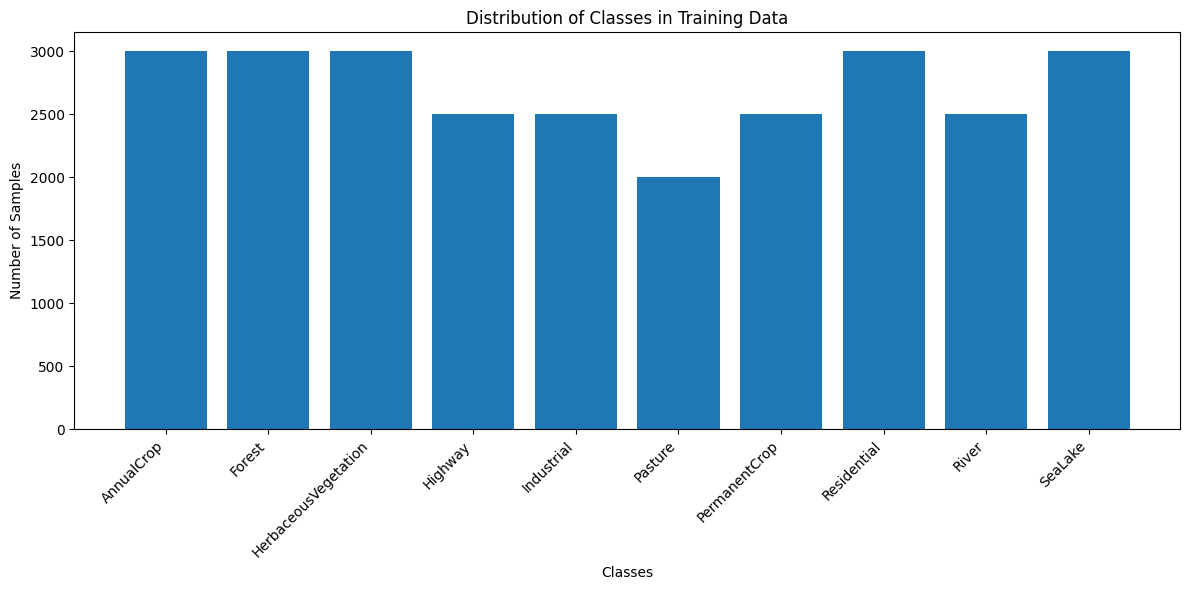

In [8]:
# Visualize class distribution
plt.figure(figsize=(12, 6))
class_names = [IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]
counts = [label_counts.get(i, 0) for i in range(NUM_CLASSES)]

plt.bar(class_names, counts)
plt.title('Distribution of Classes in Training Data')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04716981132075472..1.276661514683153].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34065934065934067..1.8273211117681856].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34065934065934067..1.8273211117681856].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.33509449298923005..1.8242811501597445].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.061245365042833365..1.2820094601206984].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.33509449298923005..1.8242811501597445].
Clipping input d

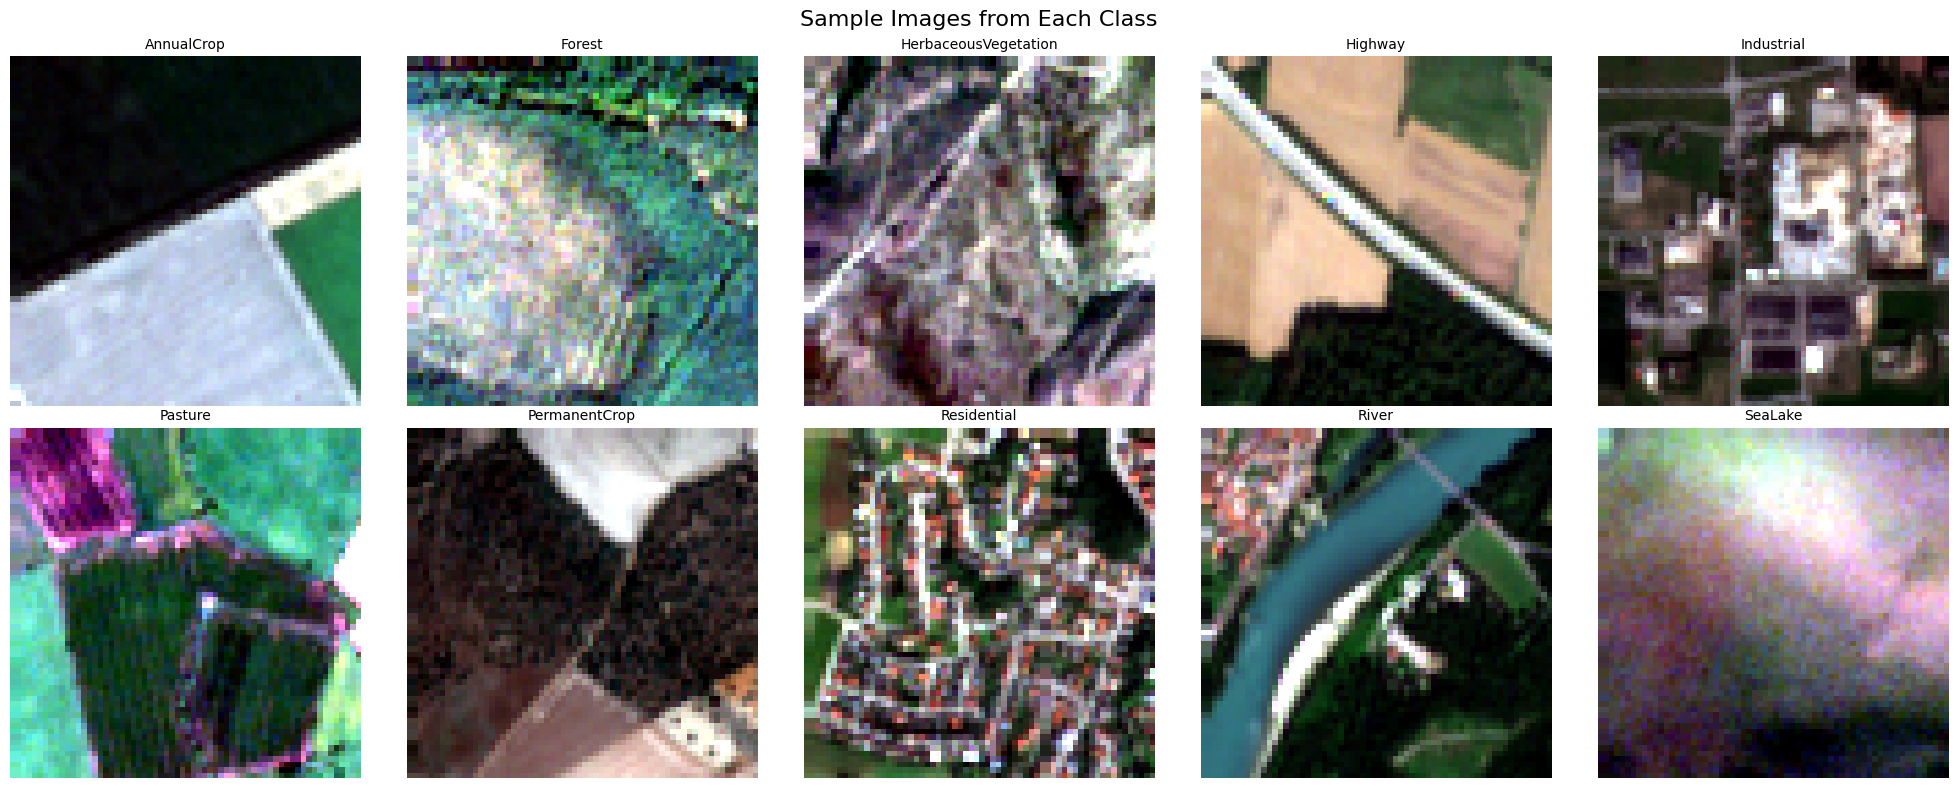

In [9]:
# Visualize sample images from each class
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, class_name in enumerate(CLASSES):
    # Find a sample from this class
    class_samples = [s for s in train_samples if class_name in s]
    if class_samples:
        sample_path = class_samples[0]
        
        # Load and display
        with rio.open(sample_path, "r") as f:
            img = f.read([1,2,3,4,5,6,7,8,9,10,11,12,13])
            img = reshape_as_image(img)
        
        normalized_img = normalize_for_display(img)
        rgb_img = normalized_img[:, :, [3, 2, 1]]
        
        axes[i].imshow(rgb_img)
        axes[i].set_title(class_name, fontsize=10)
        axes[i].axis('off')

plt.suptitle('Sample Images from Each Class', fontsize=16)
plt.tight_layout()
plt.show()

## 6. Train/Validation Split

In [10]:
# Split training data into train and validation sets
train_paths, val_paths, train_labels_split, val_labels_split = train_test_split(
    train_samples, train_labels, 
    test_size=CONFIG['validation_split'], 
    stratify=train_labels,
    random_state=42
)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")

# Create datasets
train_dataset = EuroSATDataset(train_paths, train_labels_split, transform=train_transforms)
val_dataset = EuroSATDataset(val_paths, val_labels_split, transform=val_transforms)
test_dataset = EuroSATDataset(test_samples, transform=val_transforms, is_test=True)

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True, 
    num_workers=CONFIG['num_workers']
    )
val_loader = DataLoader(
    val_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False, 
    num_workers=CONFIG['num_workers']
    )
test_loader = DataLoader(
    test_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False, 
    num_workers=CONFIG['num_workers']
    )

Training samples: 21600
Validation samples: 5400


## 7. Model Architecture

In [11]:
class EuroSATClassifier(nn.Module):
    """
    Improved CNN model for EuroSAT classification optimized for multi-spectral data.
    
    Architecture features:
    - Simplified network to reduce overfitting
    - Appropriate receptive field for 64x64 images
    - Batch normalization for training stability
    - Moderate dropout for regularization
    - Global average pooling to reduce parameters
    """
    
    def __init__(self, num_classes=NUM_CLASSES, input_channels=12):
        super(EuroSATClassifier, self).__init__()
        
        # Initial convolution to process multi-spectral input
        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Feature extraction blocks - SIMPLIFIED to reduce overfitting
        self.features = nn.Sequential(
            # Block 1: 64x64 -> 32x32
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2),
            
            # Block 2: 32x32 -> 16x16
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.3),
            
            # Block 3: 16x16 -> 8x8
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.4),
            
            # Block 4: 8x8 -> 4x4
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.4),
            
            # Global Average Pooling
            nn.AdaptiveAvgPool2d(1)
        )
        
        # Classifier head - SIMPLIFIED
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):
        """Initialize model weights using He initialization for ReLU networks."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        # Process multi-spectral input
        x = self.initial_conv(x)
        
        # Extract features
        x = self.features(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Classify
        x = self.classifier(x)
        
        return x

# Initialize model with 12 input channels (matching train and test data)
model = EuroSATClassifier(num_classes=NUM_CLASSES, input_channels=12)
model = model.to(CONFIG['device'])

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model configured for 12-channel input (cirrus band excluded)")

Total parameters: 1,038,730
Trainable parameters: 1,038,730
Model configured for 12-channel input (cirrus band excluded)


## 8. Training Setup

In [12]:
# Loss function with label smoothing to prevent overconfident predictions
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Use Adam optimizer with weight decay for L2 regularization
optimizer = optim.Adam(
    model.parameters(), 
    lr=CONFIG['learning_rate'], 
    weight_decay=CONFIG['weight_decay']  # L2 regularization
)

# Add learning rate scheduling for better convergence
# Using CosineAnnealingWarmRestarts for better generalization
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,  # Restart every 10 epochs
    T_mult=2,  # Double the restart period after each restart
    eta_min=1e-7  # Minimum learning rate
)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print(f"Optimizer: Adam with learning rate {CONFIG['learning_rate']} and weight decay {CONFIG['weight_decay']}")
print(f"Scheduler: CosineAnnealingWarmRestarts for better generalization")

Optimizer: Adam with learning rate 0.0001 and weight decay 0.0001
Scheduler: CosineAnnealingWarmRestarts for better generalization


## 9. Training and Validation Functions

In [13]:
def mixup_data(x, y, alpha=0.2, device='cpu'):
    """Apply mixup augmentation to data and labels."""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Compute mixup loss."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_epoch(model, train_loader, criterion, optimizer, device, use_mixup=True):
    """Train the model for one epoch with optional mixup augmentation."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        # Apply mixup augmentation
        if use_mixup and np.random.rand() > 0.5:  # Apply mixup 50% of the time
            mixed_data, target_a, target_b, lam = mixup_data(data, target, alpha=0.2, device=device)
            optimizer.zero_grad()
            output = model(mixed_data)
            loss = mixup_criterion(criterion, output, target_a, target_b, lam)
        else:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
        
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Synchronize if using Metal to ensure accurate loss values
        if device.type == 'mps':
            torch.mps.synchronize()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{100*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """Validate the model for one epoch."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            # Synchronize if using Metal to ensure accurate loss values
            if device.type == 'mps':
                torch.mps.synchronize()
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{100*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

## 10. Training Loop

In [14]:
# Implement training loop with early stopping
import time

print("Starting training...")
print(f"Device: {CONFIG['device']} ({'Metal GPU' if CONFIG['device'].type == 'mps' else 'CUDA GPU' if CONFIG['device'].type == 'cuda' else 'CPU'})")
best_val_acc = 0.0
patience_counter = 0
early_stopping_patience = 10

# Training timing
training_start_time = time.time()

for epoch in range(CONFIG['num_epochs']):
    print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
    print("-" * 50)
    
    epoch_start_time = time.time()
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, CONFIG['device'])
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, CONFIG['device'])
    
    epoch_elapsed = time.time() - epoch_start_time
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Epoch time: {epoch_elapsed:.2f}s")
    
    # Print Metal memory usage if available
    if CONFIG['device'].type == 'mps':
        try:
            allocated = torch.mps.current_allocated_memory() / 1024**2
            print(f"Metal GPU memory allocated: {allocated:.1f} MB")
        except:
            pass
    elif CONFIG['device'].type == 'cuda':
        try:
            allocated = torch.cuda.memory_allocated(CONFIG['device']) / 1024**2
            reserved = torch.cuda.memory_reserved(CONFIG['device']) / 1024**2
            print(f"GPU memory - Allocated: {allocated:.1f} MB, Reserved: {reserved:.1f} MB")
        except:
            pass
    
    # Update learning rate scheduler (step every epoch for CosineAnnealingWarmRestarts)
    scheduler.step()
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'history': history
        }, 'best_model.pth')
        print(f"New best model saved with validation accuracy: {best_val_acc:.2f}%")
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= early_stopping_patience:
        print(f"Early stopping triggered after {patience_counter} epochs without improvement")
        break
    
    # Print current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current learning rate: {current_lr:.2e}")

total_training_time = time.time() - training_start_time
print(f"\nTraining completed. Best validation accuracy: {best_val_acc:.2f}%")
print(f"Total training time: {total_training_time:.2f}s ({total_training_time/60:.2f} minutes)")

Starting training...
Device: mps (Metal GPU)

Epoch 1/3
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 2.0901 | Train Acc: 18.19%
Val Loss: 1.9377 | Val Acc: 27.13%
Epoch time: 113.71s
Metal GPU memory allocated: 26.3 MB
New best model saved with validation accuracy: 27.13%
Current learning rate: 9.76e-05

Epoch 2/3
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 1.8655 | Train Acc: 29.96%
Val Loss: 1.6333 | Val Acc: 45.31%
Epoch time: 111.45s
Metal GPU memory allocated: 26.4 MB
New best model saved with validation accuracy: 45.31%
Current learning rate: 9.05e-05

Epoch 3/3
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 1.7324 | Train Acc: 35.96%
Val Loss: 1.4728 | Val Acc: 55.02%
Epoch time: 110.22s
Metal GPU memory allocated: 26.4 MB
New best model saved with validation accuracy: 55.02%
Current learning rate: 7.94e-05

Training completed. Best validation accuracy: 55.02%
Total training time: 335.49s (5.59 minutes)


## 11. Training Visualization

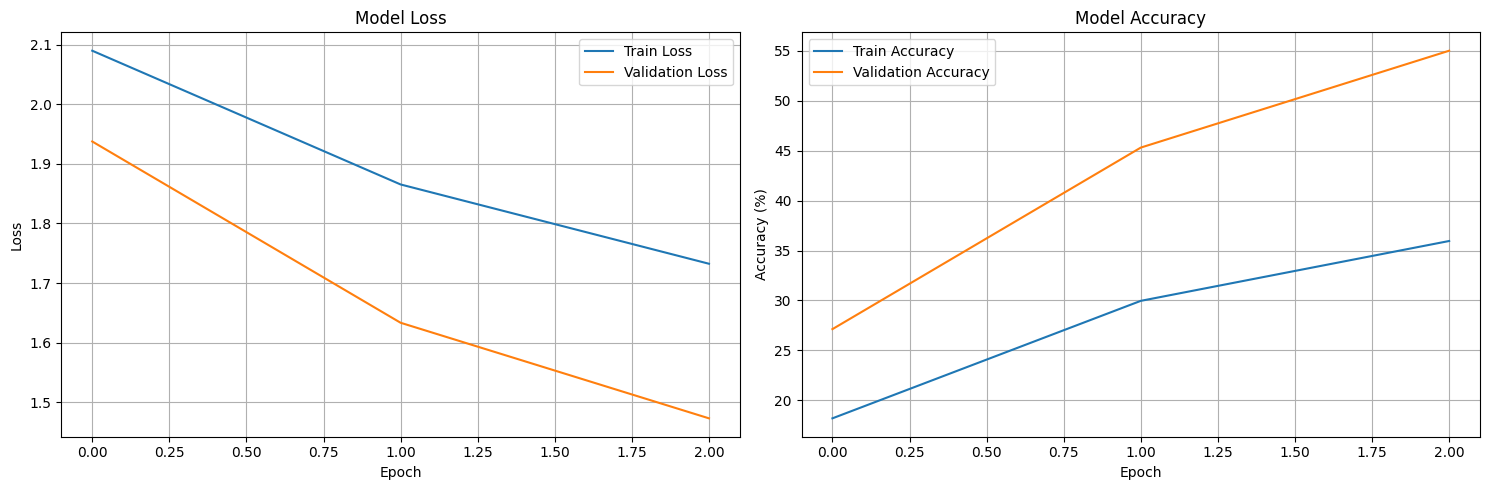

In [15]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 12. Model Evaluation

In [16]:
# Load best model for evaluation
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']} with validation accuracy: {checkpoint['best_val_acc']:.2f}%")

# Get predictions on validation set
val_predictions = []
val_true_labels = []

with torch.no_grad():
    for data, target in tqdm(val_loader, desc='Getting validation predictions'):
        data, target = data.to(CONFIG['device']), target.to(CONFIG['device'])
        output = model(data)
        _, predicted = torch.max(output, 1)
        
        val_predictions.extend(predicted.cpu().numpy())
        val_true_labels.extend(target.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(val_true_labels, val_predictions, target_names=CLASSES))

Loaded best model from epoch 2 with validation accuracy: 55.02%


Getting validation predictions:   0%|          | 0/169 [00:00<?, ?it/s]

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.38      0.93      0.54       600
              Forest       0.96      0.72      0.83       600
HerbaceousVegetation       0.32      0.37      0.34       600
             Highway       0.00      0.00      0.00       500
          Industrial       0.52      0.86      0.65       500
             Pasture       0.50      0.02      0.03       400
       PermanentCrop       0.44      0.37      0.40       500
         Residential       0.90      0.82      0.86       600
               River       0.28      0.11      0.16       500
             SeaLake       0.77      0.98      0.86       600

            accuracy                           0.55      5400
           macro avg       0.51      0.52      0.47      5400
        weighted avg       0.52      0.55      0.49      5400



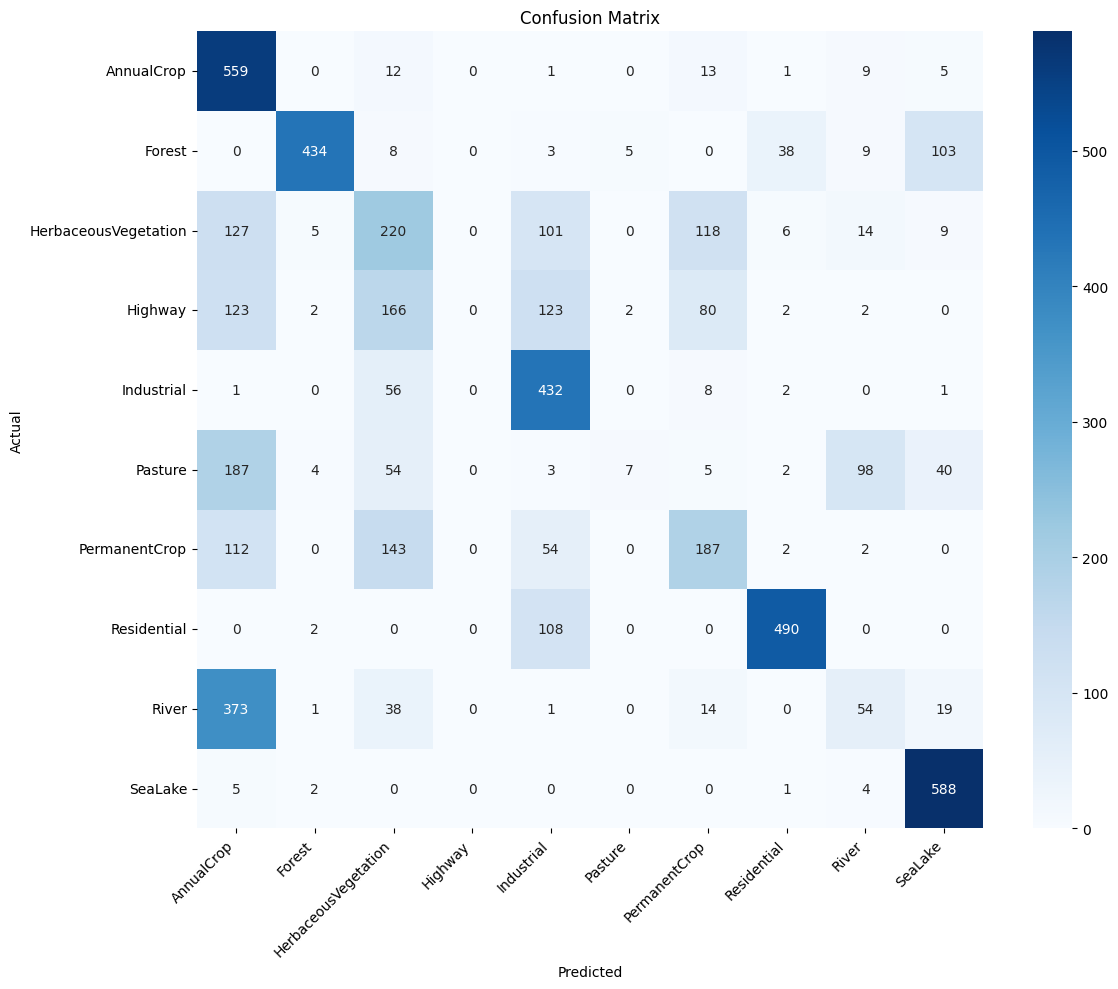

In [17]:
# Confusion matrix
cm = confusion_matrix(val_true_labels, val_predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 13. Domain Shift Analysis

In [18]:
# TODO: Analyze domain shift between training and test data
# This is crucial for this challenge as mentioned in the notebook

def analyze_domain_shift():
    """
    Analyze potential domain shift between training and test data.
    
    TODO: Implement analysis techniques:
    - Statistical comparison of band values
    - Distribution comparison (histograms, KL divergence)
    - Principal Component Analysis (PCA)
    - Feature visualization with t-SNE or UMAP
    """
    
    # Sample some training and test data for comparison
    sample_train_data = []
    sample_test_data = []
    
    # Get training samples
    for i in range(min(100, len(train_samples))):
        with rio.open(train_samples[i], "r") as f:
            img = f.read([1,2,3,4,5,6,7,8,9,10,11,12,13])
            img = reshape_as_image(img)
            sample_train_data.append(img.flatten())
    
    # Get test samples
    for i in range(min(100, len(test_samples))):
        img = np.load(test_samples[i])
        sample_test_data.append(img.flatten())
    
    sample_train_data = np.array(sample_train_data)
    sample_test_data = np.array(sample_test_data)
    
    # Compare statistics
    print("Training data statistics (mean, std):")
    print(f"Mean: {sample_train_data.mean():.4f}, Std: {sample_train_data.std():.4f}")
    
    print("Test data statistics (mean, std):")
    print(f"Mean: {sample_test_data.mean():.4f}, Std: {sample_test_data.std():.4f}")
    
    # TODO: Add more sophisticated analysis
    
analyze_domain_shift()

Training data statistics (mean, std):
Mean: 1893.4361, Std: 1184.0058
Test data statistics (mean, std):
Mean: 1292.1000, Std: 1268.1987


## 14. Domain Adaptation Techniques

In [19]:
# TODO: Implement domain adaptation techniques to address domain shift
# Possible approaches:
# 1. Test Time Adaptation (TTA)
# 2. Domain Adversarial Training
# 3. Self-training/Pseudo-labeling on test data
# 4. Statistical normalization alignment
# 5. Fine-tuning on a subset of test data (if allowed)

def apply_test_time_adaptation(model, test_loader):
    """
    Apply Test Time Adaptation techniques.
    
    TODO: Implement TTA strategies:
    - Entropy minimization
    - Batch normalization adaptation
    - Self-supervised objectives
    """
    pass

def normalize_test_data_with_train_stats(test_data, train_stats):
    """
    Normalize test data using training data statistics.
    
    TODO: Implement proper normalization alignment
    """
    pass

# Placeholder for domain adaptation implementation
print("TODO: Implement domain adaptation techniques")

TODO: Implement domain adaptation techniques


## 15. Test Set Predictions

In [20]:
# Generate predictions on test set with Test-Time Augmentation (TTA)
def predict_with_tta(model, data, device, n_augmentations=5):
    """
    Apply Test-Time Augmentation for more robust predictions.
    Average predictions across multiple augmented versions of the input.
    """
    model.eval()
    predictions = []
    
    with torch.no_grad():
        # Original prediction
        output = model(data)
        predictions.append(torch.softmax(output, dim=1))
        
        # Augmented predictions
        for _ in range(n_augmentations - 1):
            # Apply random augmentations
            augmented = data.clone()
            
            # Random horizontal flip
            if torch.rand(1) > 0.5:
                augmented = torch.flip(augmented, dims=[3])
            
            # Random vertical flip
            if torch.rand(1) > 0.5:
                augmented = torch.flip(augmented, dims=[2])
            
            # Random 90-degree rotation
            k = torch.randint(0, 4, (1,)).item()
            if k > 0:
                augmented = torch.rot90(augmented, k=k, dims=[2, 3])
            
            output = model(augmented)
            predictions.append(torch.softmax(output, dim=1))
    
    # Average all predictions
    avg_prediction = torch.stack(predictions).mean(dim=0)
    return avg_prediction

model.eval()
test_predictions = []
test_filenames = []

print("Generating predictions with Test-Time Augmentation (TTA)...")
with torch.no_grad():
    for data, filenames in tqdm(test_loader, desc='Generating test predictions'):
        data = data.to(CONFIG['device'])
        
        # Use TTA for more robust predictions
        output = predict_with_tta(model, data, CONFIG['device'], n_augmentations=8)
        _, predicted = torch.max(output, 1)
        
        test_predictions.extend(predicted.cpu().numpy())
        test_filenames.extend(filenames)

# Convert predictions to class names
test_class_predictions = [IDX_TO_CLASS[pred] for pred in test_predictions]

print(f"Generated {len(test_predictions)} predictions with TTA")
print("Sample predictions:", test_class_predictions[:10])

Generating predictions with Test-Time Augmentation (TTA)...


Generating test predictions:   0%|          | 0/133 [00:00<?, ?it/s]

Generated 4232 predictions with TTA
Sample predictions: ['SeaLake', 'River', 'Forest', 'SeaLake', 'SeaLake', 'SeaLake', 'River', 'SeaLake', 'Forest', 'Forest']


In [21]:
# Create submission file in the format of sample_submission.csv
submission_df = pd.DataFrame({
    'test_id': [int(os.path.basename(f).replace('test_', '').replace('.npy', '')) for f in test_filenames],
    'label': test_class_predictions
})

submission_df = submission_df.sort_values('test_id').reset_index(drop=True)
submission_df.to_csv('predictions.csv', index=False)

print("Submission file created: predictions.csv")
print(submission_df.head(10))

Submission file created: predictions.csv
   test_id       label
0        0     SeaLake
1        1       River
2        2     SeaLake
3        3      Forest
4        4  AnnualCrop
5        5  AnnualCrop
6        6      Forest
7        7      Forest
8        8     SeaLake
9        9     SeaLake


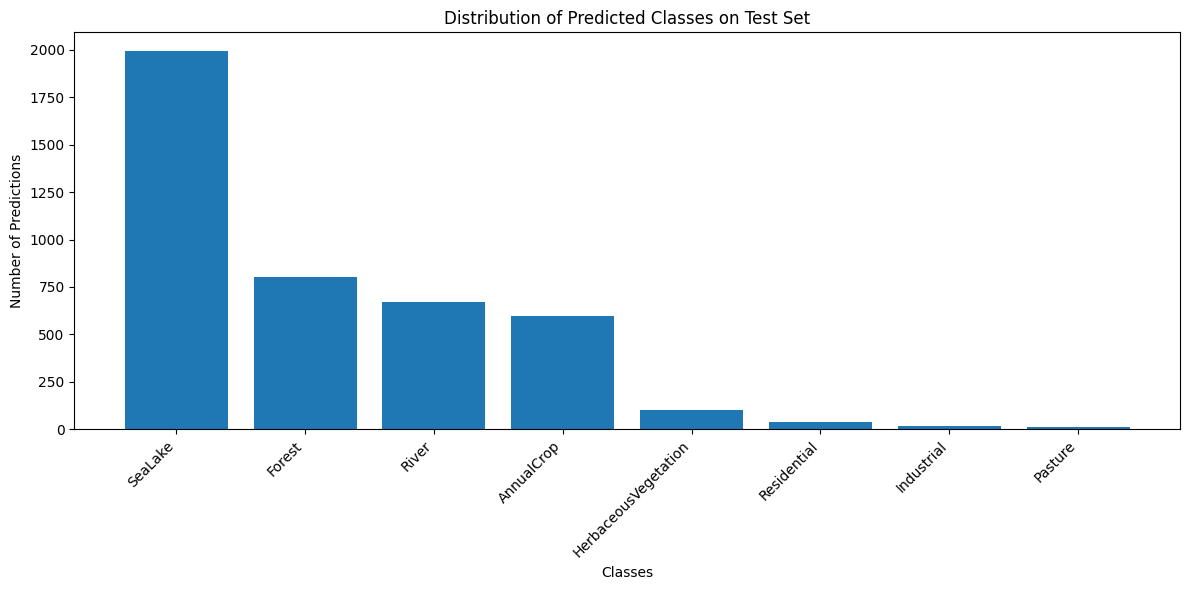

Test set prediction distribution:
  SeaLake: 1992
  Forest: 805
  River: 670
  AnnualCrop: 597
  HerbaceousVegetation: 102
  Residential: 39
  Industrial: 17
  Pasture: 10


In [22]:
# Analyze test predictions distribution
prediction_counts = pd.Series(test_class_predictions).value_counts()

plt.figure(figsize=(12, 6))
plt.bar(prediction_counts.index, prediction_counts.values)
plt.title('Distribution of Predicted Classes on Test Set')
plt.xlabel('Classes')
plt.ylabel('Number of Predictions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Test set prediction distribution:")
for class_name, count in prediction_counts.items():
    print(f"  {class_name}: {count}")

## 16. Model Interpretation and Analysis

In [23]:
# TODO: Implement model interpretation techniques
# - Gradient-based attribution methods
# - Occlusion analysis
# - Feature visualization
# - Band importance analysis for multi-spectral data

def analyze_band_importance():
    """Analyze which spectral bands are most important for classification."""
    # TODO: Implement band importance analysis
    pass

def visualize_model_attention():
    """Visualize what the model is focusing on."""
    # TODO: Implement attention visualization
    pass

print("TODO: Implement model interpretation and analysis")

TODO: Implement model interpretation and analysis


## 17. Error Analysis

In [24]:
# TODO: Perform detailed error analysis
# - Identify most confused classes
# - Analyze failure cases
# - Visualize misclassified samples

def analyze_misclassified_samples():
    """Analyze samples that were misclassified."""
    # TODO: Implement error analysis
    pass

def analyze_class_confusion():
    """Analyze which classes are most often confused."""
    # TODO: Implement class confusion analysis
    pass

print("TODO: Implement error analysis")

TODO: Implement error analysis


## 18. Model Improvements

In [25]:
# TODO: Ideas for model improvements:
# 1. Advanced architectures (ResNet, EfficientNet, Vision Transformers)
# 2. Multi-scale feature extraction
# 3. Attention mechanisms
# 4. Ensemble methods
# 5. Advanced data augmentation
# 6. Transfer learning from pre-trained models
# 7. Multi-task learning (e.g., NDVI regression as auxiliary task)
# 8. Advanced regularization techniques

print("TODO: Implement model improvements")
print("Consider:")
print("- Advanced CNN architectures (ResNet, EfficientNet)")
print("- Vision Transformers")
print("- Ensemble methods")
print("- Advanced data augmentation")
print("- Transfer learning")
print("- Multi-task learning")

TODO: Implement model improvements
Consider:
- Advanced CNN architectures (ResNet, EfficientNet)
- Vision Transformers
- Ensemble methods
- Advanced data augmentation
- Transfer learning
- Multi-task learning


## 19. Final Evaluation and Summary

In [26]:
# Summary of results
print("="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Total Training Samples: {len(train_paths):,}")
print(f"Total Validation Samples: {len(val_paths):,}")
print(f"Total Test Samples: {len(test_samples):,}")
print(f"Model Parameters: {trainable_params:,}")
print(f"Training Epochs: {len(history['train_loss'])}")

# TODO: Add more comprehensive evaluation metrics
# - Per-class accuracy
# - F1-scores
# - Model confidence analysis
# - Uncertainty quantification

print("\nTODO: Complete implementation of all sections marked with TODO")
print("Focus areas for improvement:")
print("1. Implement proper data normalization")
print("2. Design better model architecture")  
print("3. Add data augmentation techniques")
print("4. Address domain shift between train and test data")
print("5. Implement domain adaptation methods")
print("6. Add model interpretation and error analysis")
print("7. Experiment with advanced techniques")

FINAL RESULTS SUMMARY
Best Validation Accuracy: 55.02%
Total Training Samples: 21,600
Total Validation Samples: 5,400
Total Test Samples: 4,232
Model Parameters: 1,038,730
Training Epochs: 3

TODO: Complete implementation of all sections marked with TODO
Focus areas for improvement:
1. Implement proper data normalization
2. Design better model architecture
3. Add data augmentation techniques
4. Address domain shift between train and test data
5. Implement domain adaptation methods
6. Add model interpretation and error analysis
7. Experiment with advanced techniques
